In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from tqdm import tqdm

# 第一部分是整体的factor validation，只找到了两个可能validate的factor

In [2]:
start_date = '2022-01-01'
end_date = '2023-01-01'

In [3]:
spy = yf.Ticker("SPY")
sp500_tickers = spy.history(period="1d")['Close'].index.tolist()

In [4]:
sp500_tickers

[Timestamp('2024-06-17 00:00:00-0400', tz='America/New_York')]

In [5]:
components_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
components_table = pd.read_html(components_url)
components_df = components_table[0]
sp500_tickers = components_df['Symbol'].tolist()

In [6]:
factor_data_list = []

In [7]:
for ticker in tqdm(sp500_tickers):
    try:
        # Get historical data
        data = yf.download(ticker, start=start_date, end=end_date)
        
        # Calculate daily returns
        data['daily_return'] = data['Adj Close'].pct_change()
        
        # Factor Calculation
        data['monthly_intraday_momentum'] = data['daily_return'].rolling(window=20, min_periods=20).sum()
        top_20_amplitude = data['High'].rolling(window=20, min_periods=20).quantile(0.8)
        bottom_20_amplitude = data['Low'].rolling(window=20, min_periods=20).quantile(0.2)
        data['amplified_adjusted_momentum'] = top_20_amplitude - bottom_20_amplitude
        data['monthly_high_low_amplitude'] = (data['High'] - data['Low']).rolling(window=20, min_periods=20).mean()
        data['normalized_upshadow'] = (data['High'] - data[['Open', 'Close']].max(axis=1)) / data['High']
        data['average_monthly_normalized_upshadow'] = data['normalized_upshadow'].rolling(window=20, min_periods=20).mean()
        data['average_turnover'] = data['Volume'].rolling(window=20, min_periods=20).mean()
        data['price_turnover_corr'] = data['Adj Close'].rolling(window=20, min_periods=20).corr(data['Volume'])
        data['turnover_nextday_return_corr'] = data['Volume'].rolling(window=20, min_periods=20).corr(data['daily_return'].shift(-1))
        data['turnover_return_corr'] = data['Volume'].rolling(window=20, min_periods=20).corr(data['daily_return'])
        
        # Add ticker column
        data['ticker'] = ticker
        
        # Append to the list
        factor_data_list.append(data[['ticker', 'monthly_intraday_momentum', 'amplified_adjusted_momentum', 
                                      'monthly_high_low_amplitude', 'average_monthly_normalized_upshadow',
                                      'average_turnover', 'price_turnover_corr',
                                      'turnover_nextday_return_corr', 'turnover_return_corr', 'daily_return']])
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2023-01-01)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [8]:
factor_data = pd.concat(factor_data_list)

In [9]:
# Remove rows with NA values for 'monthly_intraday_momentum' and 'turnover_return_corr'
factor_data = factor_data.dropna(subset=['monthly_intraday_momentum', 'turnover_return_corr'])

In [10]:
factor_data = factor_data.fillna(method='ffill')


In [11]:
na_counts = factor_data.isna().sum()
print(na_counts)

ticker                                 0
monthly_intraday_momentum              0
amplified_adjusted_momentum            0
monthly_high_low_amplitude             0
average_monthly_normalized_upshadow    0
average_turnover                       0
price_turnover_corr                    0
turnover_nextday_return_corr           0
turnover_return_corr                   0
daily_return                           0
dtype: int64


In [12]:
factor_data

,ticker,monthly_intraday_momentum,amplified_adjusted_momentum,monthly_high_low_amplitude,average_monthly_normalized_upshadow,average_turnover,price_turnover_corr,turnover_nextday_return_corr,turnover_return_corr,daily_return
Date,,,,,,,,,,
2022-02-01,MMM,-0.057449,10.690634,3.381271,0.004518,3791487.45,-0.789202,0.243353,-0.311301,0.008493
2022-02-02,MMM,-0.076058,11.115378,3.390468,0.004663,3831499.65,-0.744585,0.242238,-0.291482,-0.004599
2022-02-03,MMM,-0.085572,12.518393,3.300586,0.004174,3810946.40,-0.655110,0.258997,-0.270839,-0.013620
2022-02-04,MMM,-0.099535,12.941476,3.338212,0.004352,3903104.20,-0.639966,0.315273,-0.308170,-0.022264
2022-02-07,MMM,-0.107753,13.602008,3.297660,0.004553,3881630.05,-0.531773,0.270327,-0.310329,0.002737
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,ZTS,-0.026454,13.010007,3.630502,0.005611,2344350.00,0.178211,-0.076937,0.081236,0.005033
2022-12-27,ZTS,-0.016485,13.010007,3.651502,0.005520,2310580.00,0.222920,-0.039137,0.063185,-0.003156
2022-12-28,ZTS,-0.024712,13.010007,3.649001,0.005516,2294420.00,0.253983,-0.053498,0.083267,-0.010117


In [13]:
# Normalize the factors after handling NAs
factors = ['monthly_intraday_momentum', 'amplified_adjusted_momentum', 'monthly_high_low_amplitude',
           'average_monthly_normalized_upshadow', 'average_turnover', 'price_turnover_corr',
           'turnover_nextday_return_corr', 'turnover_return_corr']

In [14]:
for factor in factors:
    factor_data[factor] = (factor_data[factor] - factor_data[factor].mean()) / factor_data[factor].std()

In [15]:
# Factor Validation
# Calculate IC values
def calculate_ic(factor, returns):
    return factor.rolling(window=20).corr(returns)

In [21]:
factor_data

,ticker,monthly_intraday_momentum,amplified_adjusted_momentum,monthly_high_low_amplitude,average_monthly_normalized_upshadow,average_turnover,price_turnover_corr,turnover_nextday_return_corr,turnover_return_corr,daily_return
Date,,,,,,,,,,
2022-02-01,MMM,-0.557486,-0.177452,-0.170507,-0.971363,-0.096755,-1.964892,0.870388,-0.960466,0.008493
2022-02-02,MMM,-0.744120,-0.162051,-0.169439,-0.914201,-0.095260,-1.833258,0.865420,-0.898796,-0.004599
2022-02-03,MMM,-0.839549,-0.111180,-0.179878,-1.107968,-0.096028,-1.569284,0.940119,-0.834567,-0.013620
2022-02-04,MMM,-0.979590,-0.095840,-0.175508,-1.037422,-0.092585,-1.524604,1.190960,-0.950721,-0.022264
2022-02-07,MMM,-1.062008,-0.071890,-0.180218,-0.957531,-0.093387,-1.205405,0.990623,-0.957440,0.002737
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,ZTS,-0.246618,-0.093355,-0.141560,-0.538250,-0.150820,0.889250,-0.557236,0.260927,0.005033
2022-12-27,ZTS,-0.146634,-0.093355,-0.139121,-0.574412,-0.152081,1.021152,-0.388751,0.204760,-0.003156
2022-12-28,ZTS,-0.229147,-0.093355,-0.139411,-0.576139,-0.152685,1.112797,-0.452761,0.267245,-0.010117


In [30]:
ic_values = {}
for factor in factors:
    ic_values[factor] = calculate_ic(factor_data[factor], factor_data['daily_return'])

# Aggregate IC values across the entire market
aggregate_ic = {factor: ic_values[factor].mean() for factor in factors}

In [31]:
aggregate_ic

{'monthly_intraday_momentum': 0.24712171410367317,
 'amplified_adjusted_momentum': 0.03497361884202192,
 'monthly_high_low_amplitude': 0.02007661566096169,
 'average_monthly_normalized_upshadow': 0.03801795472419708,
 'average_turnover': 0.04618732725377623,
 'price_turnover_corr': 0.03895099942217684,
 'turnover_nextday_return_corr': 0.013415859223327428,
 'turnover_return_corr': 0.06075244407694475}

In [32]:
factor_returns = {}
for factor in factors:
    factor_returns[factor] = factor_data[factor] * factor_data['daily_return']

aggregate_returns = {factor: factor_returns[factor].groupby(factor_data.index).mean().cumsum() for factor in factors}

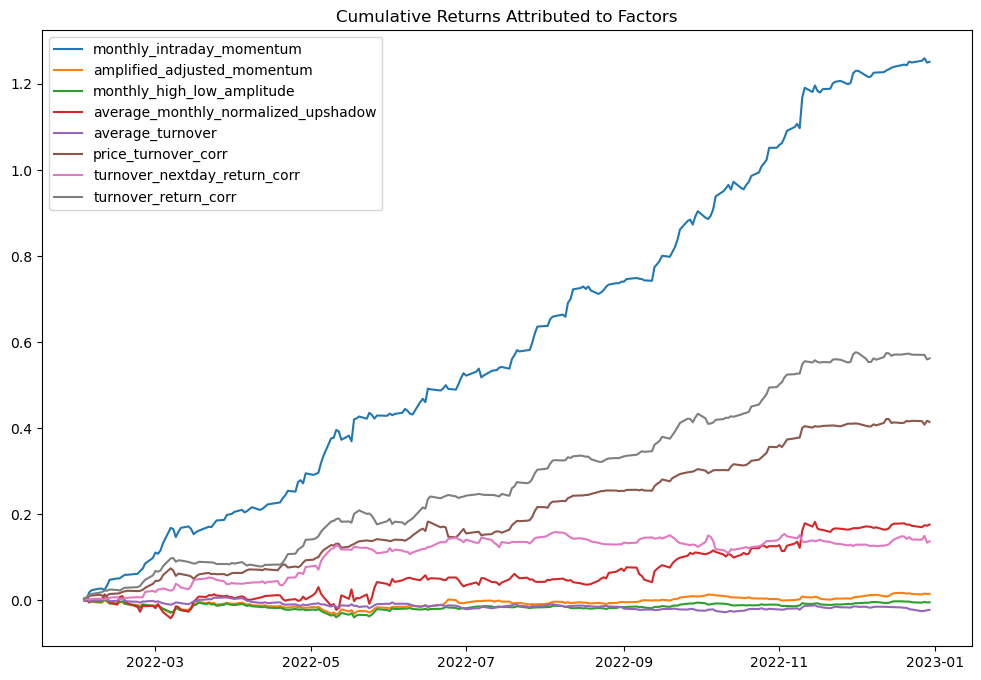

In [33]:
plt.figure(figsize=(12, 8))
for factor, ret in aggregate_returns.items():
    plt.plot(ret.index, ret.values, label=factor)
plt.legend()
plt.title('Cumulative Returns Attributed to Factors')
plt.show()

# 第二部分添加了一部分rebalance，但是可能是因为数据太少导致rebalance之后的portfolio不是很好，也可能是我代码写错了

In [34]:
factor_data['combined_score'] = factor_data['monthly_intraday_momentum'] + factor_data['turnover_return_corr']


In [35]:
# Select the top 15 stocks based on the combined score
top_stocks = factor_data.groupby('ticker')['combined_score'].mean().nlargest(15).index

In [36]:
top_stocks

Index(['SMCI', 'ENPH', 'FSLR', 'OXY', 'MRNA', 'CEG', 'PTC', 'LW', 'REGN',
       'FICO', 'STLD', 'GILD', 'CSGP', 'PODD', 'LVS'],
      dtype='object', name='ticker')

In [37]:
backtest_data = pd.DataFrame()

In [38]:
# Select the data for the top 15 stocks
for ticker in top_stocks:
    data = factor_data[factor_data['ticker'] == ticker]
    data = data[['ticker', 'daily_return']]
    backtest_data = pd.concat([backtest_data, data])

In [39]:
backtest_data_pivot = backtest_data.pivot(columns='ticker', values='daily_return')

In [41]:
backtest_data_pivot = backtest_data_pivot.fillna(0)

In [42]:
portfolio_returns = backtest_data_pivot.mean(axis=1)

In [43]:
portfolio_returns

Date
2022-02-01    0.011768
2022-02-02    0.003138
2022-02-03   -0.026739
2022-02-04    0.003840
2022-02-07    0.000464
                ...   
2022-12-23   -0.003364
2022-12-27   -0.011537
2022-12-28   -0.018769
2022-12-29    0.008070
2022-12-30    0.001469
Length: 231, dtype: float64

In [44]:
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

In [45]:
cumulative_returns

Date
2022-02-01    0.011768
2022-02-02    0.014942
2022-02-03   -0.012196
2022-02-04   -0.008403
2022-02-07   -0.007943
                ...   
2022-12-23    0.549347
2022-12-27    0.531473
2022-12-28    0.502728
2022-12-29    0.514856
2022-12-30    0.517082
Length: 231, dtype: float64

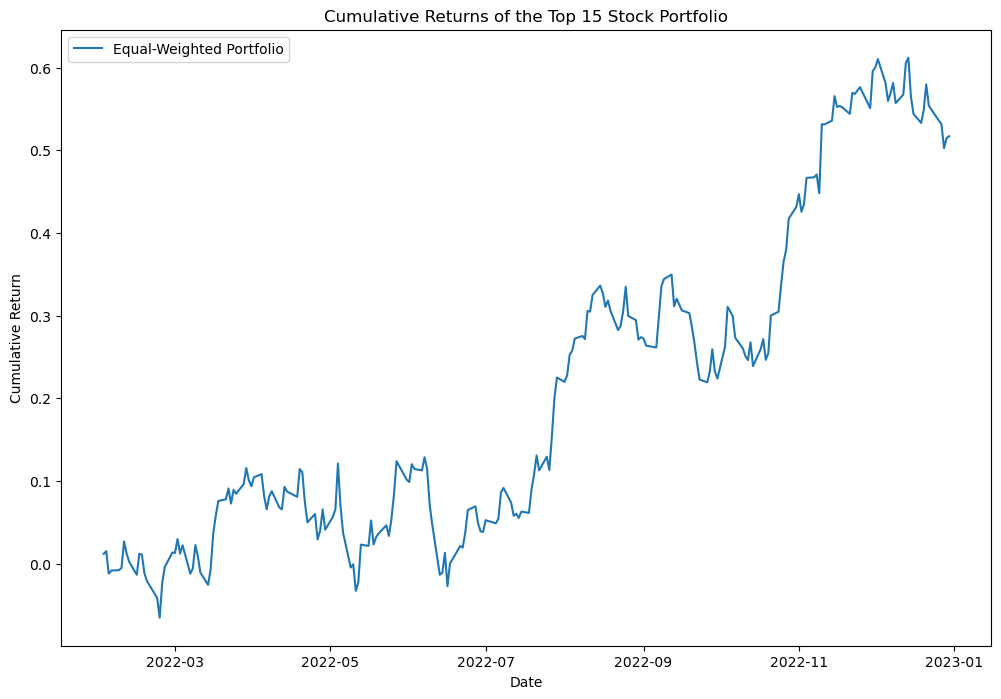

In [46]:
# Plot the cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns.index, cumulative_returns, label='Equal-Weighted Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [54]:
all_data = {}

In [55]:
for ticker in tqdm(sp500_tickers):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['daily_return'] = data['Adj Close'].pct_change()
        all_data[ticker] = data
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$BF.B: possibly delisted; No price data found  (1d 2022-01-01 -> 2023-01-01)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [62]:
factor_data_V = pd.DataFrame()

In [63]:
for ticker, data in all_data.items():
    try:
        data['monthly_intraday_momentum'] = data['daily_return'].rolling(window=20).sum()
        data['turnover_return_corr'] = data['Volume'].rolling(window=20).corr(data['daily_return'])
        data['ticker'] = ticker
        factor_data_V = pd.concat([factor_data_V, data[['ticker', 'monthly_intraday_momentum', 'turnover_return_corr', 'daily_return']]])
    except Exception as e:
        print(f"Failed to calculate factors for {ticker}: {e}")

In [64]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return
Date,,,,
2022-01-03,MMM,NaN,NaN,NaN
2022-01-04,MMM,NaN,NaN,0.014009
2022-01-05,MMM,NaN,NaN,-0.004106
2022-01-06,MMM,NaN,NaN,-0.008301
2022-01-07,MMM,NaN,NaN,0.010955
...,...,...,...,...
2022-12-23,ZTS,-0.026454,0.081236,0.005033
2022-12-27,ZTS,-0.016485,0.063186,-0.003156
2022-12-28,ZTS,-0.024712,0.083267,-0.010117


In [65]:
factor_data_V = factor_data_V.dropna(subset=['monthly_intraday_momentum', 'turnover_return_corr'])

In [66]:
factor_data_V['monthly_intraday_momentum'] = (factor_data_V['monthly_intraday_momentum'] - factor_data_V['monthly_intraday_momentum'].mean()) / factor_data_V['monthly_intraday_momentum'].std()
factor_data_V['turnover_return_corr'] = (factor_data_V['turnover_return_corr'] - factor_data_V['turnover_return_corr'].mean()) / factor_data_V['turnover_return_corr'].std()

C:\Users\zhaoz\AppData\Local\Temp\ipykernel_12508\2934420317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['monthly_intraday_momentum'] = (factor_data_V['monthly_intraday_momentum'] - factor_data_V['monthly_intraday_momentum'].mean()) / factor_data_V['monthly_intraday_momentum'].std()
C:\Users\zhaoz\AppData\Local\Temp\ipykernel_12508\2934420317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['turnover_return_corr'] = (factor_data_V['turnover_return_corr'] - factor_data_

In [67]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return
Date,,,,
2022-02-01,MMM,-0.557489,-0.960461,0.008493
2022-02-02,MMM,-0.744122,-0.898791,-0.004599
2022-02-03,MMM,-0.839548,-0.834562,-0.013620
2022-02-04,MMM,-0.979587,-0.950718,-0.022264
2022-02-07,MMM,-1.062009,-0.957437,0.002737
...,...,...,...,...
2022-12-23,ZTS,-0.246617,0.260927,0.005033
2022-12-27,ZTS,-0.146636,0.204763,-0.003156
2022-12-28,ZTS,-0.229146,0.267247,-0.010117


In [81]:
factor_data_V['combined_score'] = factor_data_V['monthly_intraday_momentum'] + factor_data_V['turnover_return_corr']

C:\Users\zhaoz\AppData\Local\Temp\ipykernel_12508\1367636104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_data_V['combined_score'] = factor_data_V['monthly_intraday_momentum'] + factor_data_V['turnover_return_corr']


In [88]:
factor_data_V

,ticker,monthly_intraday_momentum,turnover_return_corr,daily_return,combined_score
Date,,,,,
2022-02-01,MMM,-0.557489,-0.960461,0.008493,-1.517950
2022-02-02,MMM,-0.744122,-0.898791,-0.004599,-1.642913
2022-02-03,MMM,-0.839548,-0.834562,-0.013620,-1.674111
2022-02-04,MMM,-0.979587,-0.950718,-0.022264,-1.930306
2022-02-07,MMM,-1.062009,-0.957437,0.002737,-2.019446
...,...,...,...,...,...
2022-12-23,ZTS,-0.246617,0.260927,0.005033,0.014310
2022-12-27,ZTS,-0.146636,0.204763,-0.003156,0.058128
2022-12-28,ZTS,-0.229146,0.267247,-0.010117,0.038101


In [111]:
# Weekly rebalance logic
rebalance_period = 13  #可以调
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq='B')[::rebalance_period]

In [112]:
# Initialize a DataFrame to store the rebalanced portfolio returns 就是给一个基础数据
rebalanced_portfolio_returns = pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='B'), data=0.0)


In [113]:
current_portfolio = pd.DataFrame(columns=['ticker', 'shares', 'weight'])

In [114]:
# Initialize variables to track portfolio value
initial_capital = 1000000
portfolio_value = initial_capital
cash = initial_capital
portfolio_returns = []

In [119]:
def calculate_portfolio_value(current_portfolio, all_data, date):
    value = 0
    for _, row in current_portfolio.iterrows():
        value += row['shares'] * all_data[row['ticker']]['Adj Close'].loc[date]
    return value

In [117]:
# Debugging function to print current portfolio state
def print_portfolio_state(date, portfolio_value, cash, current_portfolio):
    print(f"Date: {date}")
    print(f"Portfolio Value: {portfolio_value}")
    print(f"Cash: {cash}")
    print("Current Portfolio:")
    print(current_portfolio)
    print("\n")

In [120]:
# Initialize portfolio on the first rebalance date
for date in rebalance_dates:
    try:
        if current_portfolio.empty:
            # Select top 15 stocks based on the combined score
            top_stocks = factor_data_V.loc[factor_data_V.index <= date].groupby('ticker')['combined_score'].mean().nlargest(15)
            top_stocks_index = top_stocks.index
            top_stocks_scores = top_stocks.values

            # Assign weights based on the combined scores 我这里是score的weighted average
            weights = top_stocks_scores / top_stocks_scores.sum()

            for stock, weight in zip(top_stocks_index, weights):
                shares_to_buy = (portfolio_value * weight) / all_data[stock]['Adj Close'].loc[date]
                cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)

        current_returns = rebalanced_portfolio_returns.loc[:date].dropna()
        if not current_returns.empty:
            cumulative_return = (1 + current_returns).prod() - 1
            if cumulative_return >= 0.05:
                # Sell the best 2 stocks
                best_stocks = current_portfolio.sort_values(by='weight', ascending=False).head(2)['ticker']
                for stock in best_stocks:
                    cash += all_data[stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0]
                    current_portfolio = current_portfolio[current_portfolio['ticker'] != stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
            
            elif cumulative_return <= -0.03:
                # Sell the worst stock
                worst_stock = current_portfolio.sort_values(by='weight').head(1)['ticker'].values[0]
                cash += all_data[worst_stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == worst_stock, 'shares'].values[0]
                current_portfolio = current_portfolio[current_portfolio['ticker'] != worst_stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
        
        # Calculate portfolio returns
        portfolio_returns = []
        for stock in current_portfolio['ticker']:
            stock_return = all_data[stock]['daily_return'].loc[date:date + pd.DateOffset(days=rebalance_period)]
            if not stock_return.empty:
                portfolio_returns.append(stock_return * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0] / portfolio_value)
        
        # Check if the lengths match before assignment 这里因为之前可能是data的index或者数据length不符合，我加了一个engine去筛
        if len(portfolio_returns) > 0 and len(np.sum(portfolio_returns, axis=0)) == len(rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)]):
            rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)] = np.sum(portfolio_returns, axis=0)
        
        # Update portfolio value
        portfolio_value = calculate_portfolio_value(current_portfolio, all_data, date) + cash
        
        # Print the current state of the portfolio
        print_portfolio_state(date, portfolio_value, cash, current_portfolio)
    except Exception as e:
        print(f"Failed to process rebalance for {date}: {e}")

Date: 2022-01-03 00:00:00
Portfolio Value: 851963.1642781275
Cash: -8.731149137020111e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  1879.243962  0.084990
1     HAL  2622.668946  0.079902
2     XOM  1047.129926  0.077447
3     OXY  1966.295554  0.075276
4    FICO   143.203704  0.073389
5     GLW  1821.467872  0.071719
6     UPS   338.943460  0.070271
7     APA  2127.386431  0.066337
8     PKG   439.360189  0.060767
9     MOS  1407.847506  0.060171
10    MRO  2926.840577  0.059759
11    AXP   307.011678  0.057720
12     BX   466.051427  0.055167
13   CTRA  2782.816738  0.053994
14    EOG   541.288778  0.053090


Date: 2022-01-20 00:00:00
Portfolio Value: 890729.8048458365
Cash: -8.731149137020111e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  1879.243962  0.084990
1     HAL  2622.668946  0.079902
2     XOM  1047.129926  0.077447
3     OXY  1966.295554  0.075276
4    FICO   143.203704  0.073389
5     GLW  1821.467872  0.071719
6     UPS   338.94346

In [121]:
# Calculate the cumulative returns for the rebalanced portfolio
rebalanced_cumulative_returns = (1 + rebalanced_portfolio_returns).cumprod() - 1

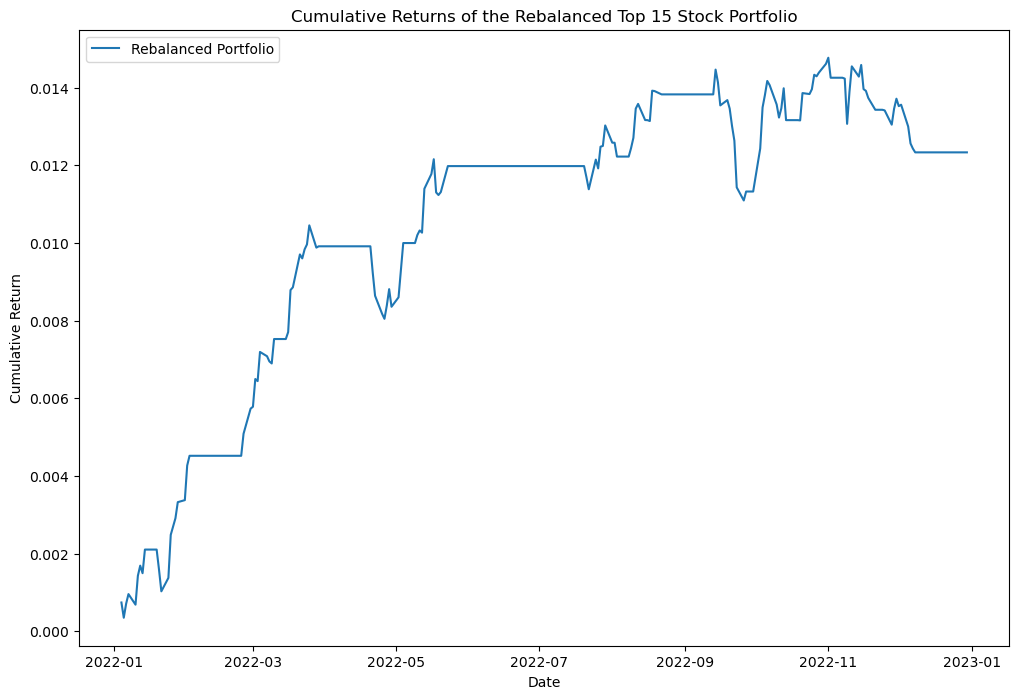

In [122]:
# Plot the cumulative returns for the rebalanced portfolio
plt.figure(figsize=(12, 8))
plt.plot(rebalanced_cumulative_returns.index, rebalanced_cumulative_returns, label='Rebalanced Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Rebalanced Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [123]:
# Initialize portfolio on the first rebalance date with out using .mean() 这我就把上边copy下来然后把选股的逻辑改了一下，没啥大变化
for date in rebalance_dates:
    try:
        if current_portfolio.empty:
            # Select top 15 stocks based on the latest combined score
            latest_scores = factor_data_V.loc[date]
            top_stocks = latest_scores.nlargest(15, 'combined_score')
            top_stocks_index = top_stocks['ticker']
            top_stocks_scores = top_stocks['combined_score']

            # Assign weights based on the combined scores
            weights = top_stocks_scores / top_stocks_scores.sum()

            for stock, weight in zip(top_stocks_index, weights):
                shares_to_buy = (portfolio_value * weight) / all_data[stock]['Adj Close'].loc[date]
                cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)

        current_returns = rebalanced_portfolio_returns.loc[:date].dropna()
        if not current_returns.empty:
            cumulative_return = (1 + current_returns).prod() - 1
            if cumulative_return >= 0.05:
                # Sell the best 2 stocks
                best_stocks = current_portfolio.sort_values(by='weight', ascending=False).head(2)['ticker']
                for stock in best_stocks:
                    cash += all_data[stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0]
                    current_portfolio = current_portfolio[current_portfolio['ticker'] != stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
            
            elif cumulative_return <= -0.03:
                # Sell the worst stock
                worst_stock = current_portfolio.sort_values(by='weight').head(1)['ticker'].values[0]
                cash += all_data[worst_stock]['Adj Close'].loc[date] * current_portfolio.loc[current_portfolio['ticker'] == worst_stock, 'shares'].values[0]
                current_portfolio = current_portfolio[current_portfolio['ticker'] != worst_stock]
                
                # Buy other stocks with the highest score
                for stock, weight in zip(top_stocks_index, weights):
                    if stock not in current_portfolio['ticker'].values:
                        shares_to_buy = (cash * weight) / all_data[stock]['Adj Close'].loc[date]
                        cash -= shares_to_buy * all_data[stock]['Adj Close'].loc[date]
                        current_portfolio = current_portfolio.append({'ticker': stock, 'shares': shares_to_buy, 'weight': weight}, ignore_index=True)
        
        # Calculate portfolio returns
        portfolio_returns = []
        for stock in current_portfolio['ticker']:
            stock_return = all_data[stock]['daily_return'].loc[date:date + pd.DateOffset(days=rebalance_period)]
            if not stock_return.empty:
                portfolio_returns.append(stock_return * current_portfolio.loc[current_portfolio['ticker'] == stock, 'shares'].values[0] / portfolio_value)
        
        # Check if the lengths match before assignment
        if len(portfolio_returns) > 0 and len(np.sum(portfolio_returns, axis=0)) == len(rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)]):
            rebalanced_portfolio_returns.loc[date:date + pd.DateOffset(days=rebalance_period)] = np.sum(portfolio_returns, axis=0)
        
        # Update portfolio value
        portfolio_value = calculate_portfolio_value(current_portfolio, all_data, date) + cash
        
        # Print the current state of the portfolio
        print_portfolio_state(date, portfolio_value, cash, current_portfolio)
    except Exception as e:
        print(f"Failed to process rebalance for {date}: {e}")

Date: 2022-01-03 00:00:00
Portfolio Value: 851963.1642781275
Cash: -8.731149137020111e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  1879.243962  0.084990
1     HAL  2622.668946  0.079902
2     XOM  1047.129926  0.077447
3     OXY  1966.295554  0.075276
4    FICO   143.203704  0.073389
5     GLW  1821.467872  0.071719
6     UPS   338.943460  0.070271
7     APA  2127.386431  0.066337
8     PKG   439.360189  0.060767
9     MOS  1407.847506  0.060171
10    MRO  2926.840577  0.059759
11    AXP   307.011678  0.057720
12     BX   466.051427  0.055167
13   CTRA  2782.816738  0.053994
14    EOG   541.288778  0.053090


Date: 2022-01-20 00:00:00
Portfolio Value: 890729.8048458365
Cash: -8.731149137020111e-11
Current Portfolio:
   ticker       shares    weight
0     LVS  1879.243962  0.084990
1     HAL  2622.668946  0.079902
2     XOM  1047.129926  0.077447
3     OXY  1966.295554  0.075276
4    FICO   143.203704  0.073389
5     GLW  1821.467872  0.071719
6     UPS   338.94346

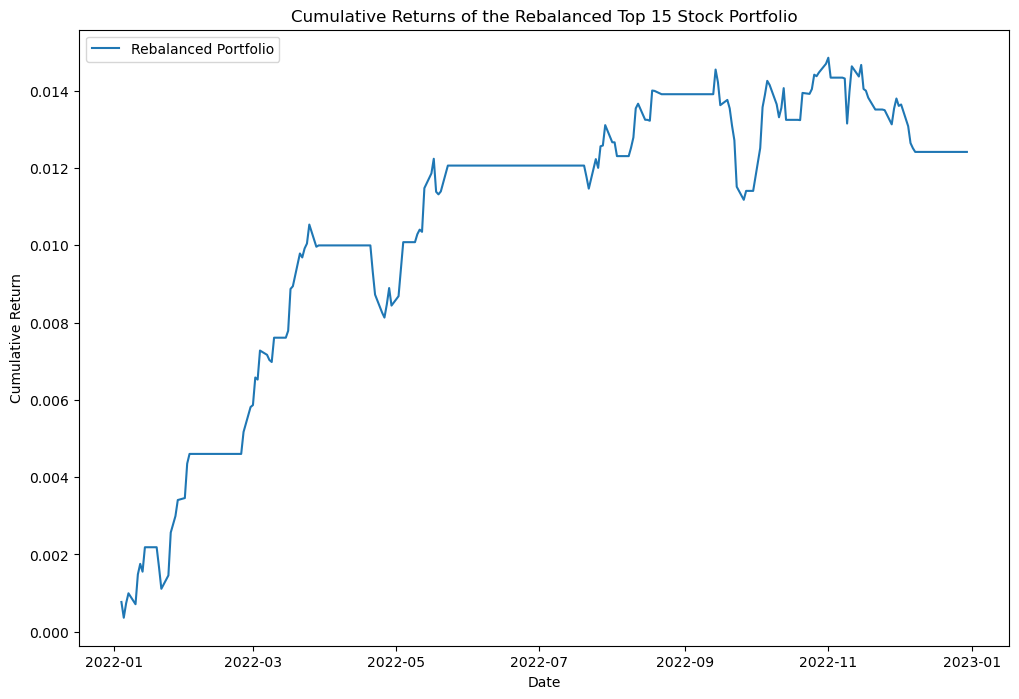

In [124]:
# Calculate the cumulative returns for the rebalanced portfolio
rebalanced_cumulative_returns = (1 + rebalanced_portfolio_returns).cumprod() - 1

# Plot the cumulative returns for the rebalanced portfolio
plt.figure(figsize=(12, 8))
plt.plot(rebalanced_cumulative_returns.index, rebalanced_cumulative_returns, label='Rebalanced Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Rebalanced Top 15 Stock Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# 如果是从buy and hold的角度来看，这个因子的整体回报还不错，但是rebalance这一块感觉有点问题，可能是我风控方面的一些问题也可能是整体交易逻辑的问题